In [2]:
import os
import wfdb
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
def load_mitbih_dataset(path):
    annots_list = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']
    X = []
    y = []
    annot_to_int = {annot: i for i, annot in enumerate(annots_list)}
    record_list = []
    with open(os.path.join(path, 'RECORDS'), 'r') as file:
        record_list = [line.strip() for line in file]
    scaler = MinMaxScaler(feature_range=(0, 1))
    for record_name in record_list:
        record = wfdb.rdrecord(os.path.join(path, record_name))
        annotation = wfdb.rdann(os.path.join(path, record_name), 'atr')
        signal = record.p_signal[:, 0]
        beat_annotations = annotation.symbol
        beat_locations = annotation.sample
        for sym, loc in zip(beat_annotations, beat_locations):
            if sym in annots_list:
                label = annot_to_int[sym]
                win_size = 625
                if loc - win_size >= 0 and loc + win_size <= len(signal):
                    segment = signal[loc - win_size: loc + win_size]
                    segment = scaler.fit_transform(segment.reshape(-1, 1)).flatten()
                    X.append(segment)
                    y.append(label)
    X = np.array(X)
    y = to_categorical(y, num_classes=len(annots_list))
    return X, y

In [2]:
def create_lstm_only_model(num_classes, input_shape=(1250, 1), optimizer_type='adam', learning_rate=0.001):
    inputs = Input(shape=input_shape)
    x = LSTM(200, return_sequences=True)(inputs)
    x = LSTM(100, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
    return model

In [4]:
def cross_validate_model(X, y, k=10, epochs=10):
    """
    Perform K-fold cross-validation on the LSTM-only model.

    Args:
    X (numpy array): Feature dataset.
    y (numpy array): Labels for the dataset.
    k (int): Number of folds for cross-validation. Default is 10.
    epochs (int): Number of epochs to train each model. Default is 10.

    Returns:
    all_results (list): List of evaluation results for each fold.
    total_elapsed_time (float): Total time taken for cross-validation.
    """

    # Initialize the KFold cross-validator with k splits, shuffling, and a fixed random seed for reproducibility
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    # Initialize variables to keep track of the fold number and results
    fold_no = 1
    all_results = []

    # Record the start time for the entire cross-validation process
    total_start_time = time.time()

    # Iterate through each fold
    for train, test in kfold.split(X, y):
        print(f'Training fold {fold_no}...')

        # Record the start time for the current fold
        fold_start_time = time.time()

        # Split the dataset into training and testing sets for the current fold
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        # Create a new instance of the LSTM-only model for the current fold
        model = create_lstm_only_model(num_classes=y_train.shape[1], input_shape=(X_train.shape[1], 1))

        # Define the file path for saving the model for the current fold
        model_checkpoint_path = f'./model_fold_{fold_no}.h5'

        # Set up callbacks for early stopping, model checkpointing, and learning rate reduction
        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),  # Stop training if validation loss doesn't improve for 10 epochs
            keras.callbacks.ModelCheckpoint(model_checkpoint_path, save_best_only=True, verbose=1),  # Save the best model based on validation loss
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)  # Reduce learning rate if validation loss doesn't improve for 5 epochs
        ]

        # Train the model on the training set and validate on the testing set
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

        # Record the end time for the current fold and calculate the elapsed time
        fold_end_time = time.time()
        fold_elapsed_time = fold_end_time - fold_start_time
        print(f'Fold {fold_no} completed in {fold_elapsed_time:.2f} seconds.')

        # Evaluate the model on the testing set and store the results
        results = model.evaluate(X_test, y_test, verbose=1)
        all_results.append(results)

        # Increment the fold number for the next iteration
        fold_no += 1

    # Record the end time for the entire cross-validation process and calculate the total elapsed time
    total_end_time = time.time()
    total_elapsed_time = total_end_time - total_start_time
    print(f'Total cross-validation time: {total_elapsed_time:.2f} seconds.')

    return all_results, total_elapsed_time

# Load and preprocess data
data_path = "/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/"
X, y = load_mitbih_dataset(data_path)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Perform cross-validation
results, total_time = cross_validate_model(X, y, k=10, epochs=10)

# Save results
with open('cross_validation_results.json', 'w') as f:
    json.dump(results, f)

print("Cross-validation completed. Results saved.")

Training fold 1...


2024-05-16 02:42:40.594717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8231 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-05-16 02:42:40.595231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8089 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:68:00.0, compute capability: 8.6


Epoch 1/10


2024-05-16 02:42:44.089274: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-16 02:42:44.902964: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb5440c60d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-16 02:42:44.903011: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-05-16 02:42:44.903023: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-05-16 02:42:44.915782: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715852565.003021  340347 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3074/3074 [==============================] - ETA: 0s - loss: 1.2151 - accuracy: 0.6845 - precision: 0.6876 - recall: 0.6533
Epoch 1: val_loss improved from inf to 1.18813, saving model to ./model_fold_1.h5
3074/3074 [==============================] - 305s 98ms/step - loss: 1.2151 - accuracy: 0.6845 - precision: 0.6876 - recall: 0.6533 - val_loss: 1.1881 - val_accuracy: 0.6868 - val_precision: 0.6868 - val_recall: 0.6868 - lr: 0.0010
Epoch 2/10
   2/3074 [..............................] - ETA: 3:34 - loss: 1.3139 - accuracy: 0.6719 - precision: 0.6667 - recall: 0.6562

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3074/3074 [==============================] - ETA: 0s - loss: 1.1965 - accuracy: 0.6853 - precision: 0.6878 - recall: 0.6668
Epoch 2: val_loss improved from 1.18813 to 1.14311, saving model to ./model_fold_1.h5
3074/3074 [==============================] - 302s 98ms/step - loss: 1.1965 - accuracy: 0.6853 - precision: 0.6878 - recall: 0.6668 - val_loss: 1.1431 - val_accuracy: 0.6868 - val_precision: 0.7037 - val_recall: 0.6202 - lr: 0.0010
Epoch 3/10
3074/3074 [==============================] - ETA: 0s - loss: 1.1475 - accuracy: 0.6853 - precision: 0.6937 - recall: 0.6557
Epoch 3: val_loss improved from 1.14311 to 1.13687, saving model to ./model_fold_1.h5
3074/3074 [==============================] - 302s 98ms/step - loss: 1.1475 - accuracy: 0.6853 - precision: 0.6937 - recall: 0.6557 - val_loss: 1.1369 - val_accuracy: 0.6868 - val_precision: 0.7045 - val_recall: 0.6261 - lr: 0.0010
Epoch 4/10
3074/3074 [==============================] - ETA: 0s - loss: 1.1379 - accuracy: 0.6853 - precisi

2024-05-16 13:53:47.109070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8231 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-05-16 13:53:47.109540: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8089 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:68:00.0, compute capability: 8.6


Model for fold 1 loaded successfully.


2024-05-16 13:53:48.444061: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


342/342 [==============================] - 16s 45ms/step - loss: 0.2198 - accuracy: 0.9411 - precision: 0.9493 - recall: 0.9351
Test Loss, Test Accuracy, and other metrics for fold 1: [0.21983303129673004, 0.9410741925239563, 0.9492847919464111, 0.9351267218589783]
Evaluation time for fold 1: 16.34 seconds
342/342 [==============================] - 14s 41ms/step

Classification Report for fold 1:
              precision    recall  f1-score   support

           N       0.95      0.99      0.97      7506
           L       0.97      0.96      0.97       806
           R       0.98      0.92      0.95       775
           e       0.00      0.00      0.00         1
           j       0.00      0.00      0.00        31
           A       0.80      0.63      0.71       221
           a       0.00      0.00      0.00        14
           J       0.00      0.00      0.00         8
           V       0.84      0.70      0.76       692
           E       0.00      0.00      0.00         7
     

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

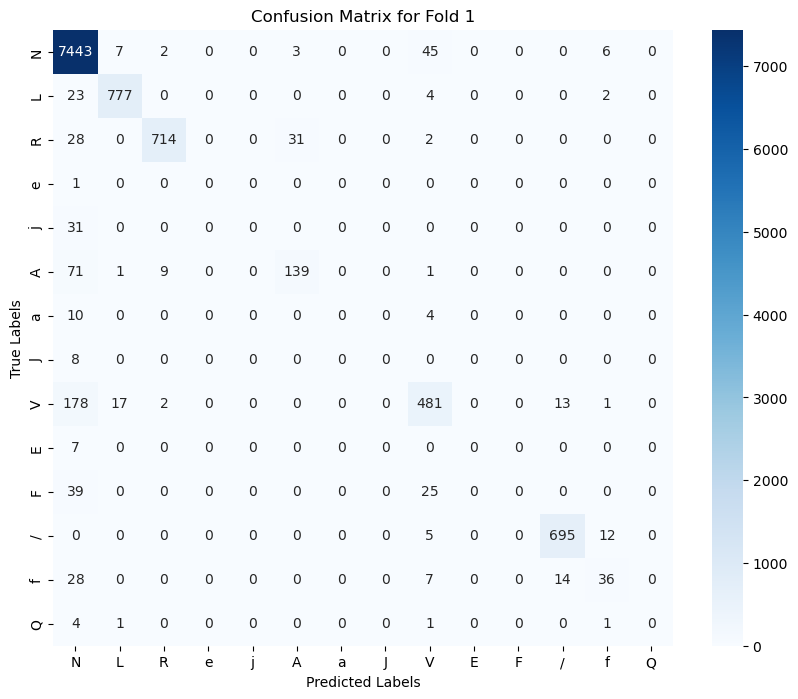

Model for fold 2 loaded successfully.
342/342 [==============================] - 16s 46ms/step - loss: 0.1894 - accuracy: 0.9529 - precision_1: 0.9601 - recall_1: 0.9493
Test Loss, Test Accuracy, and other metrics for fold 2: [0.18944993615150452, 0.9528776407241821, 0.9601147770881653, 0.9493091702461243]
Evaluation time for fold 2: 16.40 seconds
342/342 [==============================] - 14s 41ms/step

Classification Report for fold 2:
              precision    recall  f1-score   support

           N       0.96      1.00      0.98      7489
           L       0.93      0.98      0.96       788
           R       0.97      0.96      0.96       725
           e       0.00      0.00      0.00         1
           j       0.00      0.00      0.00        18
           S       0.00      0.00      0.00         1
           A       0.92      0.50      0.65       246
           a       0.00      0.00      0.00        13
           J       0.00      0.00      0.00         4
           V     

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

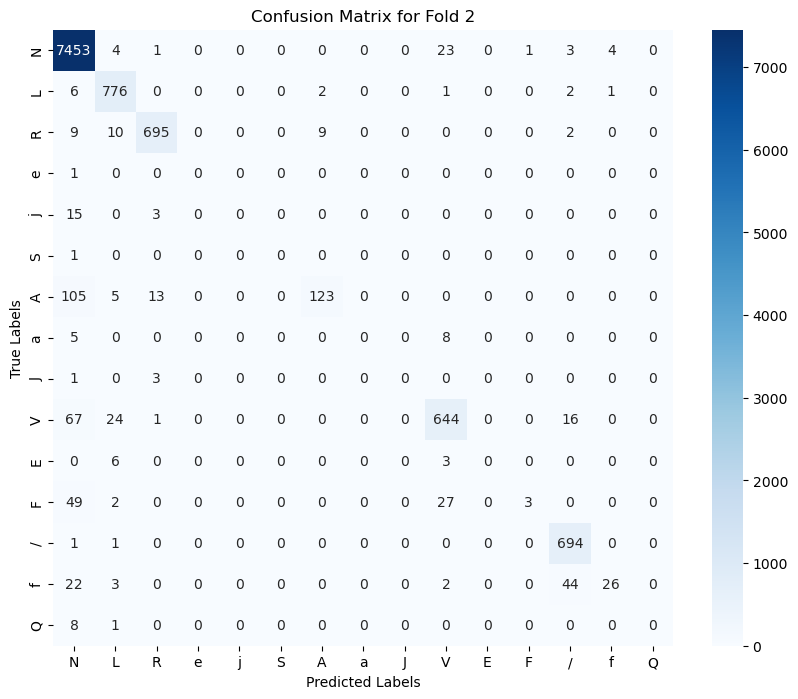

Model for fold 3 loaded successfully.
342/342 [==============================] - 16s 46ms/step - loss: 0.5813 - accuracy: 0.8167 - precision_2: 0.8766 - recall_2: 0.7478
Test Loss, Test Accuracy, and other metrics for fold 3: [0.581283450126648, 0.8167261481285095, 0.8765551447868347, 0.747826874256134]
Evaluation time for fold 3: 16.18 seconds
342/342 [==============================] - 14s 41ms/step

Classification Report for fold 3:
              precision    recall  f1-score   support

           N       0.84      0.99      0.91      7514
           L       0.79      0.55      0.65       849
           R       0.74      0.67      0.70       731
           j       0.00      0.00      0.00        23
           A       0.00      0.00      0.00       247
           a       0.00      0.00      0.00        11
           J       0.00      0.00      0.00         8
           V       0.22      0.01      0.02       707
           E       0.00      0.00      0.00        10
           F       0

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

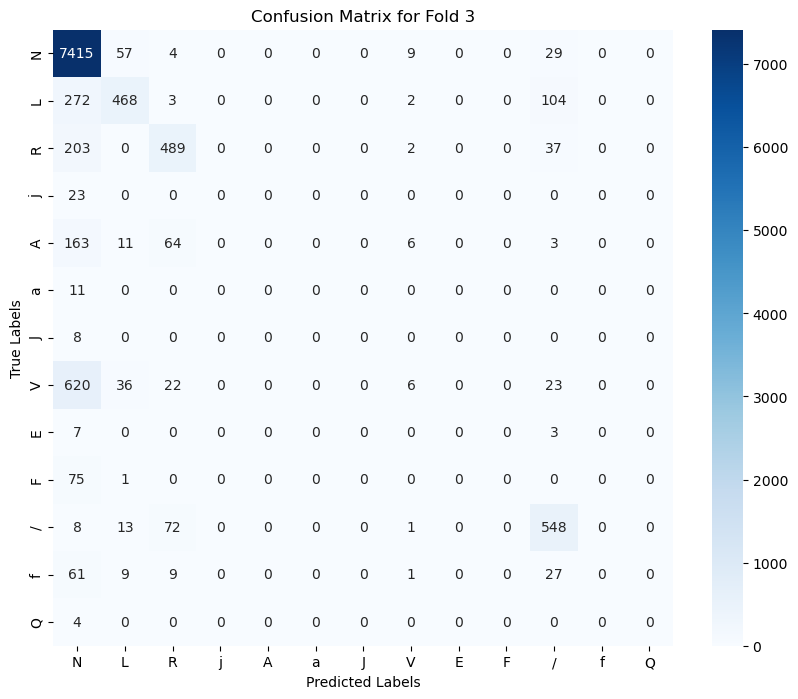

Model for fold 4 loaded successfully.
342/342 [==============================] - 16s 46ms/step - loss: 1.0071 - accuracy: 0.6939 - precision_3: 0.7318 - recall_3: 0.6525
Test Loss, Test Accuracy, and other metrics for fold 4: [1.0071184635162354, 0.6939335465431213, 0.7318349480628967, 0.6524842381477356]
Evaluation time for fold 4: 16.29 seconds
342/342 [==============================] - 15s 42ms/step

Classification Report for fold 4:
              precision    recall  f1-score   support

           N       0.70      0.99      0.82      7490
           L       0.70      0.09      0.16       833
           R       0.00      0.00      0.00       711
           e       0.00      0.00      0.00         2
           j       0.00      0.00      0.00        21
           S       0.00      0.00      0.00         1
           A       0.00      0.00      0.00       251
           a       0.00      0.00      0.00        15
           J       0.00      0.00      0.00         7
           V      

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

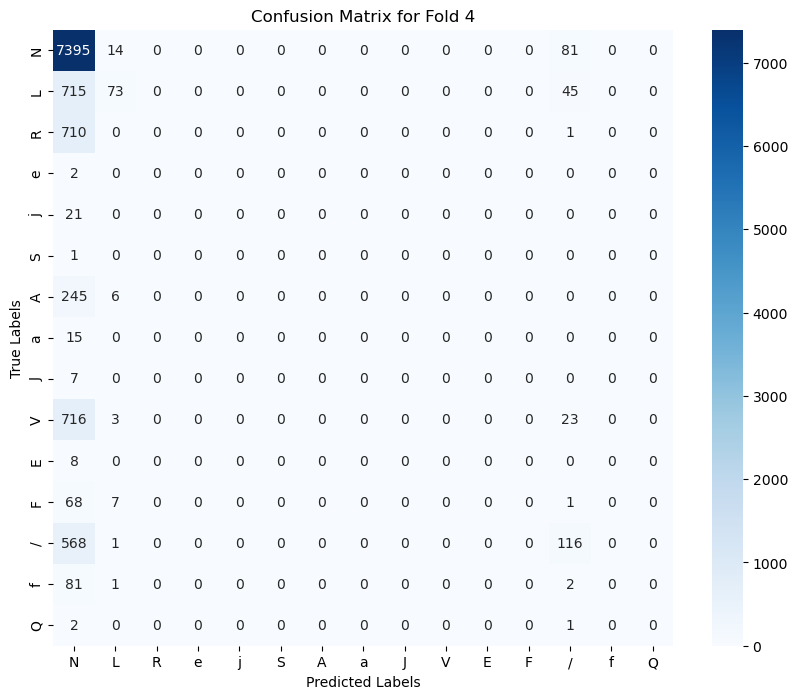

Model for fold 5 loaded successfully.
342/342 [==============================] - 16s 45ms/step - loss: 0.4659 - accuracy: 0.8552 - precision_4: 0.8929 - recall_4: 0.8132
Test Loss, Test Accuracy, and other metrics for fold 5: [0.4658893346786499, 0.8551560044288635, 0.8928965926170349, 0.8131576776504517]
Evaluation time for fold 5: 16.10 seconds
342/342 [==============================] - 14s 41ms/step

Classification Report for fold 5:
              precision    recall  f1-score   support

           N       0.90      0.96      0.93      7491
           L       0.75      0.73      0.74       799
           R       0.82      0.94      0.88       749
           e       0.00      0.00      0.00         2
           j       0.00      0.00      0.00        20
           A       0.86      0.16      0.27       278
           a       0.00      0.00      0.00        14
           J       0.00      0.00      0.00         5
           V       0.54      0.26      0.35       718
           E      

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

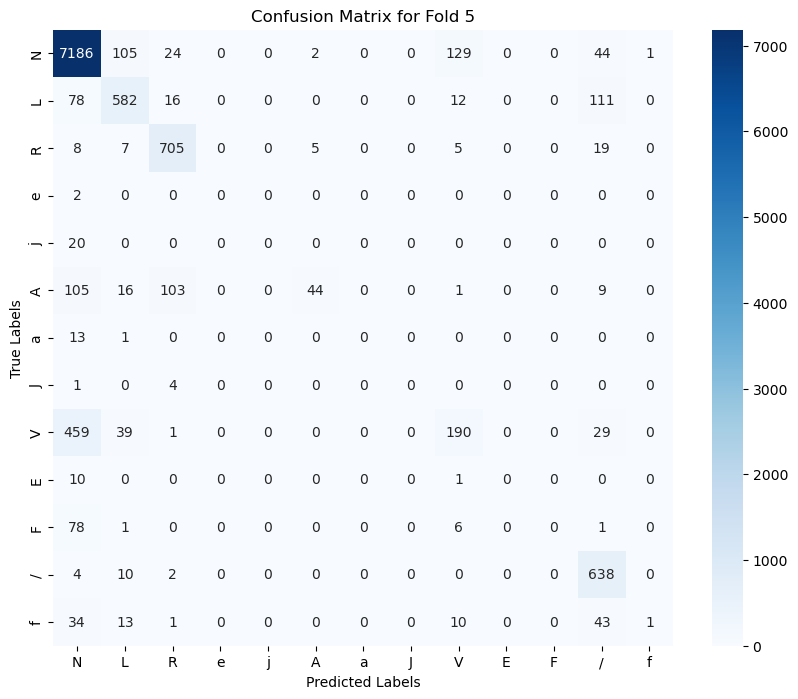

Model for fold 6 loaded successfully.
342/342 [==============================] - 16s 46ms/step - loss: 0.3327 - accuracy: 0.9041 - precision_5: 0.9229 - recall_5: 0.8865
Test Loss, Test Accuracy, and other metrics for fold 6: [0.3326863944530487, 0.9041083455085754, 0.9229376912117004, 0.886540412902832]
Evaluation time for fold 6: 16.33 seconds
342/342 [==============================] - 14s 40ms/step

Classification Report for fold 6:
              precision    recall  f1-score   support

           N       0.91      0.98      0.95      7409
           L       0.93      0.91      0.92       769
           R       0.93      0.95      0.94       752
           j       0.00      0.00      0.00        25
           A       0.83      0.46      0.59       257
           a       0.00      0.00      0.00        17
           J       0.00      0.00      0.00        12
           V       0.70      0.43      0.53       750
           E       0.00      0.00      0.00        13
           F       

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

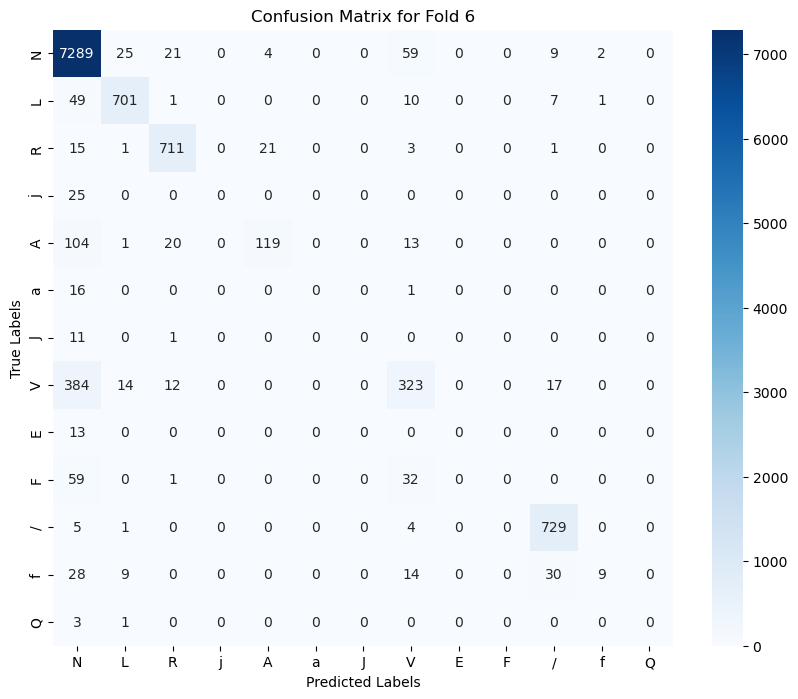

Model for fold 7 loaded successfully.
342/342 [==============================] - 16s 46ms/step - loss: 0.8404 - accuracy: 0.7201 - precision_6: 0.8087 - recall_6: 0.6424
Test Loss, Test Accuracy, and other metrics for fold 7: [0.8404126763343811, 0.7201024889945984, 0.8086846470832825, 0.6424192786216736]
Evaluation time for fold 7: 16.21 seconds
342/342 [==============================] - 14s 40ms/step

Classification Report for fold 7:
              precision    recall  f1-score   support

           N       0.76      0.95      0.85      7485
           L       0.50      0.48      0.49       792
           R       1.00      0.00      0.00       715
           e       0.00      0.00      0.00         2
           j       0.00      0.00      0.00        27
           A       0.00      0.00      0.00       281
           a       0.00      0.00      0.00        24
           J       0.00      0.00      0.00        12
           V       0.00      0.00      0.00       707
           E      

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

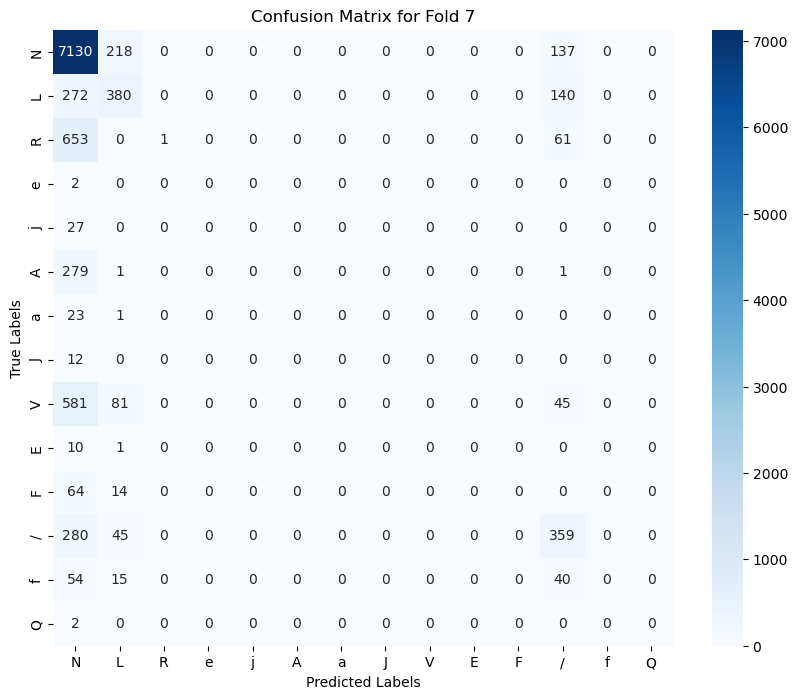

Model for fold 8 loaded successfully.
342/342 [==============================] - 16s 45ms/step - loss: 0.8385 - accuracy: 0.7260 - precision_7: 0.7890 - recall_7: 0.6421
Test Loss, Test Accuracy, and other metrics for fold 8: [0.8384627103805542, 0.726024866104126, 0.7890475392341614, 0.6421120166778564]
Evaluation time for fold 8: 15.90 seconds
342/342 [==============================] - 14s 40ms/step

Classification Report for fold 8:
              precision    recall  f1-score   support

           N       0.74      0.99      0.84      7549
           L       0.81      0.21      0.34       781
           R       0.00      0.00      0.00       687
           e       0.00      0.00      0.00         1
           j       0.00      0.00      0.00        29
           A       0.00      0.00      0.00       264
           a       0.00      0.00      0.00         8
           J       0.00      0.00      0.00         4
           V       0.00      0.00      0.00       706
           E       

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

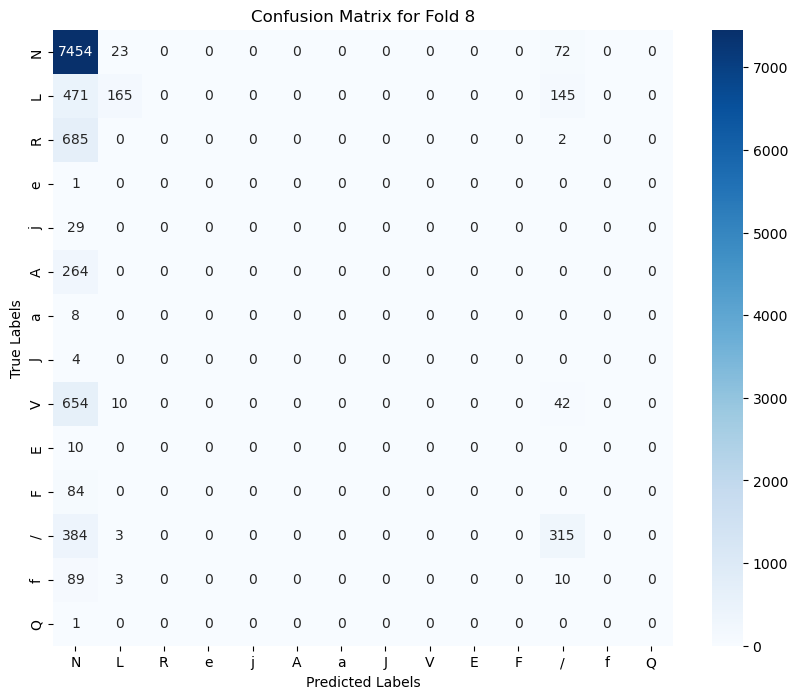

Model for fold 9 loaded successfully.
342/342 [==============================] - 17s 47ms/step - loss: 1.1161 - accuracy: 0.6837 - precision_8: 0.6837 - recall_8: 0.6837
Test Loss, Test Accuracy, and other metrics for fold 9: [1.1160683631896973, 0.683748185634613, 0.683748185634613, 0.683748185634613]
Evaluation time for fold 9: 16.60 seconds
342/342 [==============================] - 14s 39ms/step

Classification Report for fold 9:
              precision    recall  f1-score   support

           N       0.68      1.00      0.81      7472
           L       0.00      0.00      0.00       793
           R       0.00      0.00      0.00       682
           e       0.00      0.00      0.00         2
           j       0.00      0.00      0.00        21
           A       0.00      0.00      0.00       249
           a       0.00      0.00      0.00        21
           J       0.00      0.00      0.00        10
           V       0.00      0.00      0.00       710
           E       0.

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

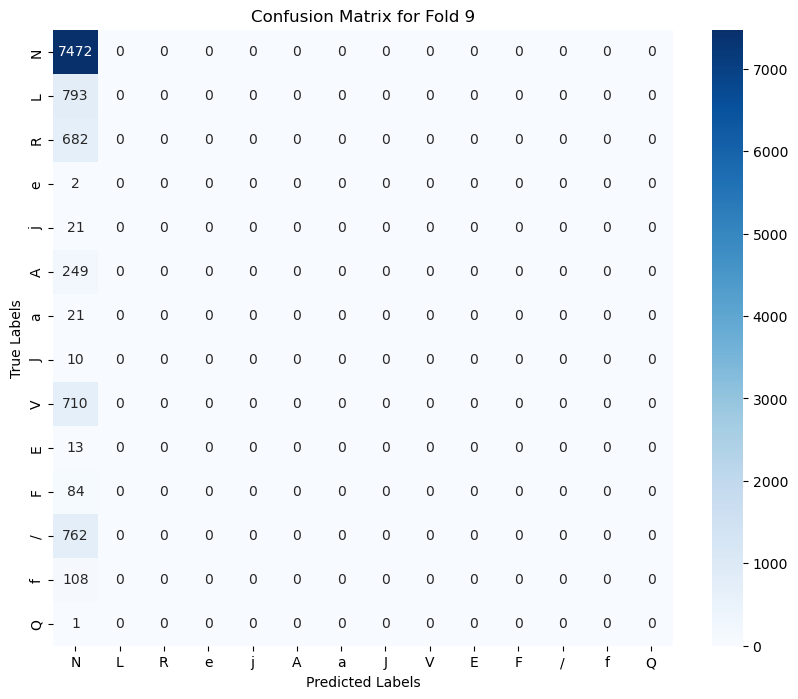

Model for fold 10 loaded successfully.
342/342 [==============================] - 16s 45ms/step - loss: 0.8996 - accuracy: 0.7221 - precision_9: 0.7916 - recall_9: 0.6319
Test Loss, Test Accuracy, and other metrics for fold 10: [0.899587094783783, 0.7220900654792786, 0.7915854454040527, 0.6318631172180176]
Evaluation time for fold 10: 15.95 seconds
342/342 [==============================] - 14s 40ms/step

Classification Report for fold 10:
              precision    recall  f1-score   support

           N       0.74      0.98      0.84      7501
           L       0.64      0.31      0.41       850
           R       0.00      0.00      0.00       718
           e       0.00      0.00      0.00         5
           j       0.00      0.00      0.00        14
           A       0.00      0.00      0.00       248
           a       0.00      0.00      0.00        13
           J       0.00      0.00      0.00        13
           V       0.00      0.00      0.00       637
           E   

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

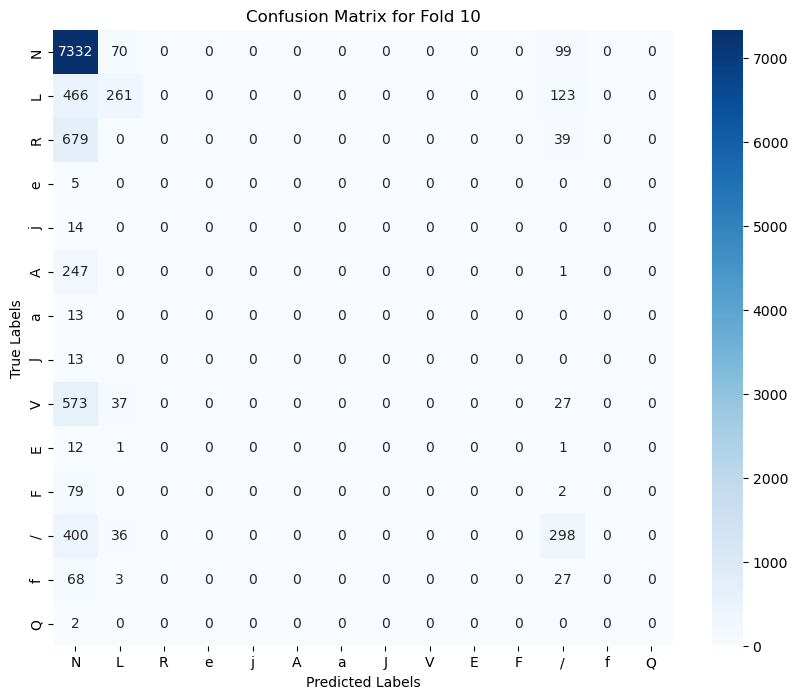


Average metrics across all folds:
Precision: 0.26668025979470966
Recall: 0.22233789075316063
F1-Score: 0.2248824378535137
Support: 788.2276923076923


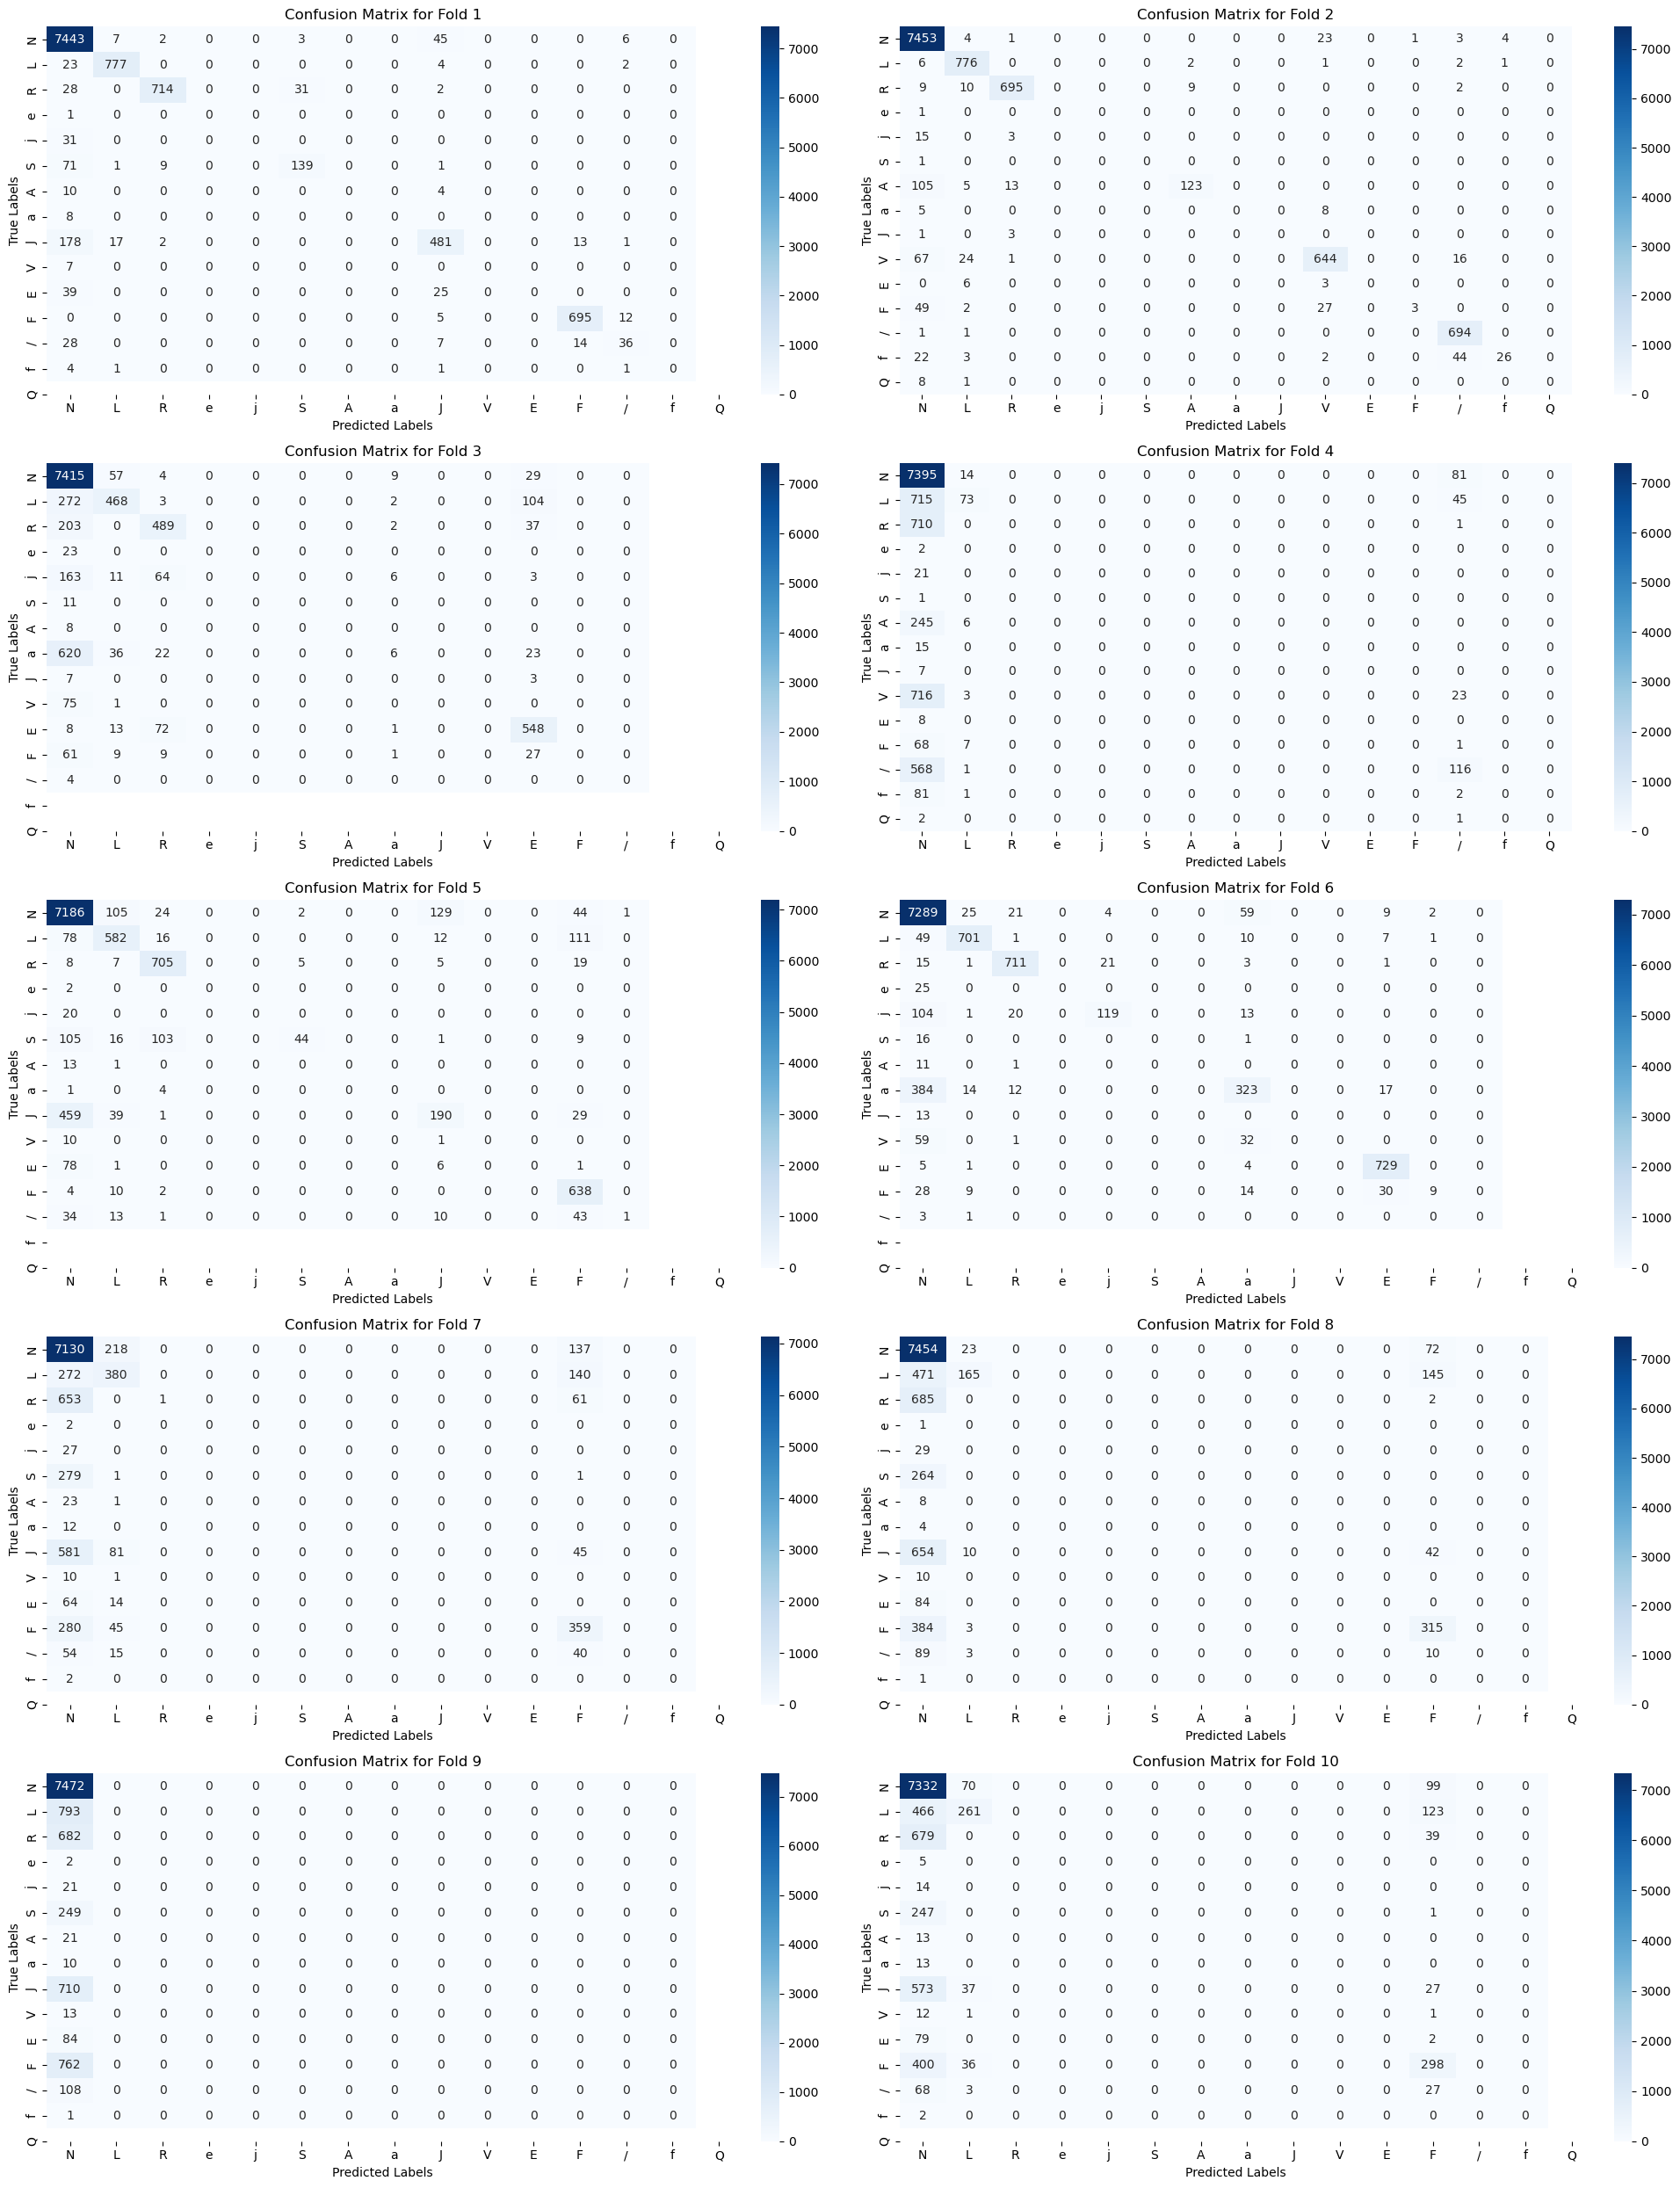

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time

# Define the class labels based on your annots_list
class_labels = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']
def evaluate_model_on_folds(X, y, k=10):
    """
    Evaluate the trained model on each fold of the K-fold cross-validation.
    
    Args:
    X (numpy array): Feature dataset.
    y (numpy array): Labels for the dataset.
    k (int): Number of folds for cross-validation. Default is 10.
    
    Returns:
    all_confusion_matrices (list): List of confusion matrices for each fold.
    all_metrics (list): List of metrics for each fold.
    """
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_no = 1
    all_confusion_matrices = []
    all_metrics = []

    for train, test in kfold.split(X, y):
        model_path = f'./model_fold_{fold_no}.h5'
        if not os.path.exists(model_path):
            print(f'Model file for fold {fold_no} not found!')
            continue
        
        # Load the trained model for the current fold
        model = keras.models.load_model(model_path)
        print(f'Model for fold {fold_no} loaded successfully.')

        X_test = X[test]
        y_test = y[test]

        # Evaluate the model on the test data and measure the time taken
        start_time = time.time()
        results = model.evaluate(X_test, y_test, verbose=1)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Test Loss, Test Accuracy, and other metrics for fold {fold_no}: {results}')
        print(f'Evaluation time for fold {fold_no}: {elapsed_time:.2f} seconds')

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        # Generate classification report and confusion matrix for the current fold
        unique_classes = np.unique(y_true_classes)
        report_dict = classification_report(y_true_classes, y_pred_classes, labels=unique_classes, target_names=[class_labels[i] for i in unique_classes], output_dict=True)
        print(f"\nClassification Report for fold {fold_no}:")
        print(classification_report(y_true_classes, y_pred_classes, labels=unique_classes, target_names=[class_labels[i] for i in unique_classes]))

        cm = confusion_matrix(y_true_classes, y_pred_classes, labels=unique_classes)
        all_confusion_matrices.append(cm)

        # Collect metrics for averaging later
        metrics = precision_recall_fscore_support(y_true_classes, y_pred_classes, labels=unique_classes)
        all_metrics.append(metrics)

        # Plot and display the confusion matrix for the current fold
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_labels[i] for i in unique_classes], yticklabels=[class_labels[i] for i in unique_classes])
        plt.title(f'Confusion Matrix for Fold {fold_no}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

        fold_no += 1

    return all_confusion_matrices, all_metrics

def calculate_average_metrics(all_metrics):
    """
    Calculate average metrics across all folds.
    
    Args:
    all_metrics (list): List of metrics for each fold.
    
    Returns:
    dict: Dictionary containing average precision, recall, F1-score, and support.
    """
    avg_precision = []
    avg_recall = []
    avg_fscore = []
    avg_support = []

    for metrics in all_metrics:
        precision, recall, fscore, support = metrics
        avg_precision.append(np.mean(precision))
        avg_recall.append(np.mean(recall))
        avg_fscore.append(np.mean(fscore))
        avg_support.append(np.mean(support))

    return {
        "avg_precision": np.mean(avg_precision),
        "avg_recall": np.mean(avg_recall),
        "avg_fscore": np.mean(avg_fscore),
        "avg_support": np.mean(avg_support)
    }

if __name__ == "__main__":
    # Load and preprocess data
    data_path = "/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/"
    X, y = load_mitbih_dataset(data_path)
    X = X.reshape((X.shape[0], X.shape[1], 1))


    # Evaluate model on each fold
    all_confusion_matrices, all_metrics = evaluate_model_on_folds(X, y, k=10)

    # Calculate and print average metrics
    average_metrics = calculate_average_metrics(all_metrics)

    print("\nAverage metrics across all folds:")
    print(f"Precision: {average_metrics['avg_precision']}")
    print(f"Recall: {average_metrics['avg_recall']}")
    print(f"F1-Score: {average_metrics['avg_fscore']}")
    print(f"Support: {average_metrics['avg_support']}")

    # Visualize all confusion matrices in one figure
    fig, axes = plt.subplots(5, 2, figsize=(20, 25))
    axes = axes.ravel()

    for i in range(10):
        sns.heatmap(all_confusion_matrices[i], annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for Fold {i+1}')
        axes[i].set_xlabel('Predicted Labels')
        axes[i].set_ylabel('True Labels')

    plt.tight_layout()
    plt.show()
